In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from testsuite import MAP_model, neg_log_lik

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [3]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest
from tfpmodels import centeredIndependentFactorAnalysisTest2
from mapper import Mapper

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_components_in_mixture = 10
n_sources = 2
n_features = 2
n_observations = 5000

In [7]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*3, mixture_component_var_rate=1.*3,data_var_concentration=.1*3,data_var_rate=10.*3)

In [8]:
ifa.unconstrained_variables

{'mixture_component_var': <tf.Variable 'ifa2/mixture_component_var:0' shape=(2, 10) dtype=float32_ref>,
 'mixture_weights': <tf.Variable 'ifa2/mixture_weights:0' shape=(2, 9) dtype=float32_ref>,
 'sources': <tf.Variable 'ifa2/sources:0' shape=(5000, 2) dtype=float32_ref>,
 'factor_loadings': <tf.Variable 'ifa2/factor_loadings:0' shape=(2, 2) dtype=float32_ref>,
 'data_var': <tf.Variable 'ifa2/data_var:0' shape=(1, 2) dtype=float32_ref>}

In [9]:
generated = sess.run(ifa.tape)

In [10]:
fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T
loss, opt = ifa.map_optimizer(data=generated['data'])
sess.run(tf.global_variables_initializer())

# Initialize in true parameters, as a sanity check
true_parameters = dict(generated)
true_parameters.pop('data')
sess.run(ifa.assigner(**true_parameters))

# FastICA, large SNR initialization
#sess.run(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
#sess.run(tf.assign(ifa.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
#sess.run(tf.assign(ifa.unconstrained_variables['data_var'], 1e-3*np.ones(ifa.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))

initialized_parameters = sess.run(ifa.variables)
#initialized_parameters.pop('sources')
train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
#opt.minimize()

In [11]:
true_parameters['data_var']

array([[0.00708986, 0.00352698]], dtype=float32)

In [12]:
true_parameters['sources'].var(0)

array([0.13476527, 0.00896734], dtype=float32)

In [13]:
map_estimates = dict(ifa.variables)
map_estimates.pop('sources')

<tf.Tensor 'ifa2/sources/read:0' shape=(5000, 2) dtype=float32>

In [14]:
testmodel,source = centeredIndependentFactorAnalysisTest2(n_observations=n_observations, **map_estimates)
source_sample = sess.run(source.distribution.sample((5000)))

In [15]:
source_sample.var(0)

array([0.14356446, 0.0094888 ], dtype=float32)

[[0.00708981 0.00352702]]
[0.14198181 0.00899098]


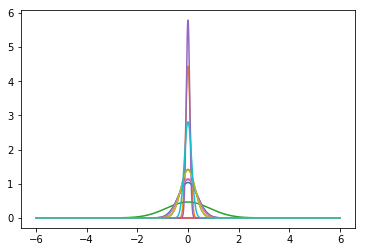

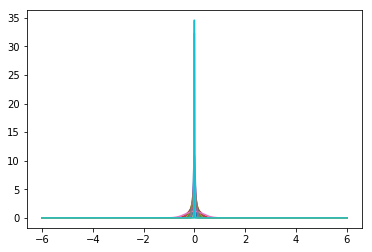

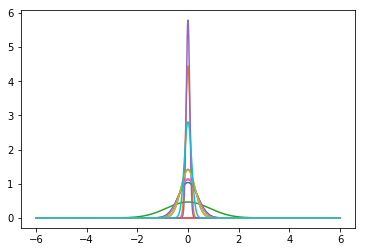

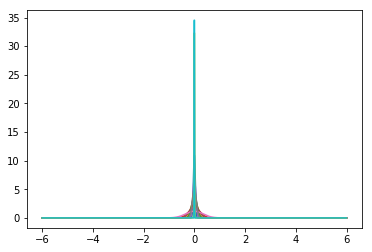

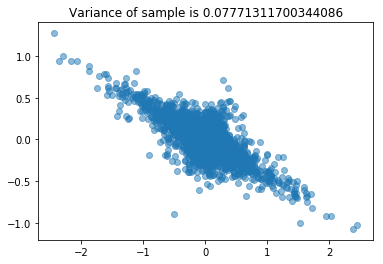

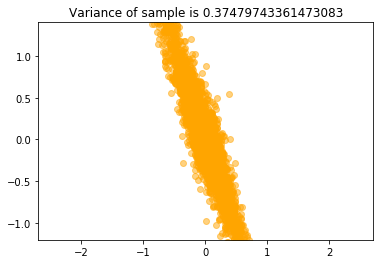

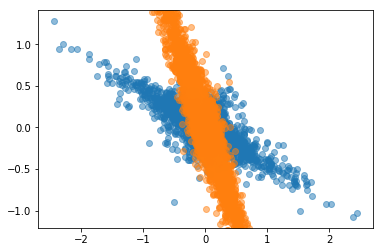

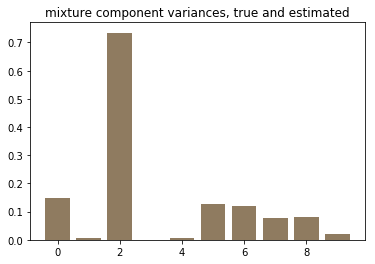

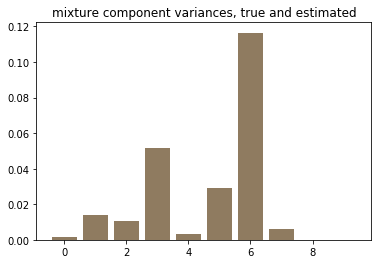

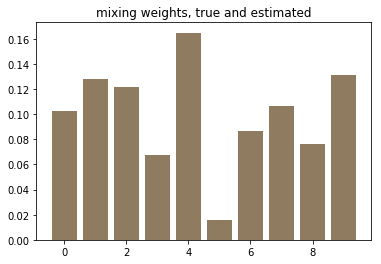

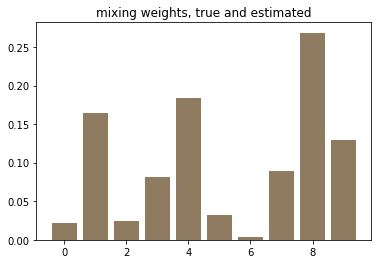

In [16]:
map_estimates = dict(ifa.variables)
map_estimates.pop('sources')

generated_vars = generated.copy()
map_estimate_vars = sess.run(map_estimates)

testmodel,source = centeredIndependentFactorAnalysisTest2(n_observations=n_observations, **map_estimates)
print(sess.run(map_estimates['data_var']))
print(sess.run(source.distribution.sample((5000))).var(0))
ppc = sess.run(testmodel.distribution.sample())

plot_source_distributions(generated['mixture_component_var'],sess)
plot_source_distributions(map_estimates['mixture_component_var'],sess)

fig, ax = plt.subplots()
plt.title('Variance of sample is {}'.format(generated['data'].var()))
plt.scatter(*generated['data'].T,alpha=.5)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.show()

fig, ax = plt.subplots()
plt.title('Variance of sample is {}'.format(ppc.var()))
plt.scatter(*ppc.T, alpha=.5,c='orange')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

fig, ax = plt.subplots()
plt.scatter(*generated['data'].T,alpha=.5)
plt.scatter(*ppc.T, alpha=.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

for source in range(n_sources):
    plt.title('mixture component variances, true and estimated')
    plt.bar(np.arange(n_components_in_mixture),generated_vars['mixture_component_var'][source,:])
    plt.bar(np.arange(n_components_in_mixture),map_estimate_vars['mixture_component_var'][source,:],alpha=.5)
    plt.show()

for source in range(n_sources):
    plt.title('mixing weights, true and estimated')
    plt.bar(np.arange(n_components_in_mixture),generated_vars['mixture_weights'][source,:])
    plt.bar(np.arange(n_components_in_mixture),map_estimate_vars['mixture_weights'][source,:],alpha=.5)
    plt.show()

In [17]:
train_nll = neg_log_lik(map_estimates,centeredIndependentFactorAnalysisTest,generated['data'])

In [18]:
sess.run(train_nll_init)

0.120033555

In [19]:
# run train_nll 100 times to estimate variance of the log-likelihood estimate
#train_nlls = []
#for i in range(100):
    #train_nlls.append(sess.run(train_nll_init))
#train_nlls = np.array(train_nlls)
#print(train_nlls)
#print(train_nlls.mean())
#print(train_nlls.std())

In [20]:
generated_vars.pop('data')
train_nll_true_model = neg_log_lik(generated_vars,centeredIndependentFactorAnalysisTest,generated['data'])

In [21]:
sess.run(train_nll_true_model)

0.11319727

In [22]:
print(generated['mixture_component_var'])
print(map_estimate_vars['mixture_component_var'])

[[1.47940174e-01 8.05743877e-03 7.34625578e-01 2.02173504e-11
  4.72479919e-03 1.26201376e-01 1.21382147e-01 7.90273473e-02
  8.13505873e-02 2.01438274e-02]
 [1.30109093e-03 1.40741477e-02 1.03143705e-02 5.16923070e-02
  3.30591761e-03 2.93143094e-02 1.16457582e-01 6.13737479e-03
  1.09968270e-04 1.80322004e-05]]
[[1.47940159e-01 8.05747043e-03 7.34625578e-01 2.02173642e-11
  4.72476752e-03 1.26201406e-01 1.21382184e-01 7.90273398e-02
  8.13505873e-02 2.01438162e-02]
 [1.30103785e-03 1.40741197e-02 1.03143752e-02 5.16923368e-02
  3.30592506e-03 2.93143094e-02 1.16457611e-01 6.13733428e-03
  1.10024121e-04 1.80004408e-05]]


In [23]:
print(generated['mixture_component_var'].mean(1))
print(map_estimate_vars['mixture_component_var'].mean(1))

[0.13234533 0.02327251]
[0.13234533 0.02327251]


In [24]:
print(generated['data_var'])
print(map_estimate_vars['data_var'])

[[0.00708986 0.00352698]]
[[0.00708981 0.00352702]]


In [25]:
fgen = generated['factor_loadings']
fpred = map_estimate_vars['factor_loadings']
fgen = 100*fgen/np.linalg.norm(fgen,axis=1,keepdims=True)
fpred = 100*fpred/np.linalg.norm(fpred,axis=1,keepdims=True)
fica_n = 100*fica/np.linalg.norm(fica, axis=1, keepdims=True)

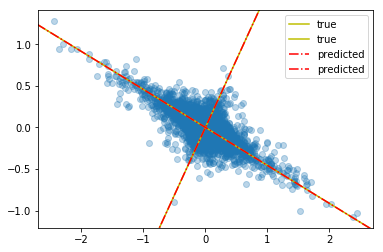

In [26]:
fig, ax = plt.subplots()
ax.scatter(*generated['data'].T,alpha=0.3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for fg in fgen:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='y',label='true')

for fg in fpred:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='r', linestyle='-.', label='predicted')

#for fg in fica_n:
#    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='k',linestyle='--',label='initial')

plt.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim);

#plt.plot((-1,1),(0,0),'k--')
#plt.plot((0,0),(-1,1),'k--')



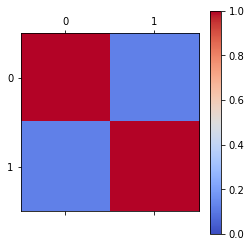

In [27]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],map_estimate_vars['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)
plt.colorbar()

In [28]:
generated_vars

OrderedDict([('mixture_component_var',
              array([[1.47940174e-01, 8.05743877e-03, 7.34625578e-01, 2.02173504e-11,
                      4.72479919e-03, 1.26201376e-01, 1.21382147e-01, 7.90273473e-02,
                      8.13505873e-02, 2.01438274e-02],
                     [1.30109093e-03, 1.40741477e-02, 1.03143705e-02, 5.16923070e-02,
                      3.30591761e-03, 2.93143094e-02, 1.16457582e-01, 6.13737479e-03,
                      1.09968270e-04, 1.80322004e-05]], dtype=float32)),
             ('mixture_weights',
              array([[0.10251232, 0.12755099, 0.1215866 , 0.0672402 , 0.16474906,
                      0.01540162, 0.08678774, 0.10624205, 0.0765    , 0.13142943],
                     [0.02194962, 0.1645556 , 0.02387679, 0.08178275, 0.18419264,
                      0.0326173 , 0.00314261, 0.08980987, 0.2684272 , 0.12964572]],
                    dtype=float32)),
             ('sources', array([[-0.03775893,  0.12177868],
                     [-0.065

In [29]:
map_estimate_vars

{'mixture_component_var': array([[1.47940159e-01, 8.05747043e-03, 7.34625578e-01, 2.02173642e-11,
         4.72476752e-03, 1.26201406e-01, 1.21382184e-01, 7.90273398e-02,
         8.13505873e-02, 2.01438162e-02],
        [1.30103785e-03, 1.40741197e-02, 1.03143752e-02, 5.16923368e-02,
         3.30592506e-03, 2.93143094e-02, 1.16457611e-01, 6.13733428e-03,
         1.10024121e-04, 1.80004408e-05]], dtype=float32),
 'mixture_weights': array([[0.10251234, 0.12755097, 0.12158658, 0.06724021, 0.16474906,
         0.01540162, 0.08678774, 0.10624205, 0.07649999, 0.13142945],
        [0.02194962, 0.16455558, 0.02387679, 0.08178275, 0.1841926 ,
         0.0326173 , 0.00314261, 0.08980986, 0.26842716, 0.12964572]],
       dtype=float32),
 'factor_loadings': array([[ 2.2675843 , -1.0351777 ],
        [-0.26456863, -0.4301053 ]], dtype=float32),
 'data_var': array([[0.00708981, 0.00352702]], dtype=float32)}

In [30]:
try:
    generated_vars.pop('sources')
except:
    pass
for param_pair in zip(generated_vars.values(),map_estimate_vars.values()):
    print(param_pair)
    print(np.allclose(*param_pair,rtol=0.001))

(array([[1.47940174e-01, 8.05743877e-03, 7.34625578e-01, 2.02173504e-11,
        4.72479919e-03, 1.26201376e-01, 1.21382147e-01, 7.90273473e-02,
        8.13505873e-02, 2.01438274e-02],
       [1.30109093e-03, 1.40741477e-02, 1.03143705e-02, 5.16923070e-02,
        3.30591761e-03, 2.93143094e-02, 1.16457582e-01, 6.13737479e-03,
        1.09968270e-04, 1.80322004e-05]], dtype=float32), array([[1.47940159e-01, 8.05747043e-03, 7.34625578e-01, 2.02173642e-11,
        4.72476752e-03, 1.26201406e-01, 1.21382184e-01, 7.90273398e-02,
        8.13505873e-02, 2.01438162e-02],
       [1.30103785e-03, 1.40741197e-02, 1.03143752e-02, 5.16923368e-02,
        3.30592506e-03, 2.93143094e-02, 1.16457611e-01, 6.13733428e-03,
        1.10024121e-04, 1.80004408e-05]], dtype=float32))
False
(array([[0.10251232, 0.12755099, 0.1215866 , 0.0672402 , 0.16474906,
        0.01540162, 0.08678774, 0.10624205, 0.0765    , 0.13142943],
       [0.02194962, 0.1645556 , 0.02387679, 0.08178275, 0.18419264,
        0.032

In [31]:
param_pair

(array([[0.00708986, 0.00352698]], dtype=float32),
 array([[0.00708981, 0.00352702]], dtype=float32))

In [32]:
np.allclose(*param_pair)

True